In [42]:
from dateutil.relativedelta import relativedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import holtwinters as hw
import statsmodels.api as sm
from wmfdata import charting, hive, mariadb
from wmfdata.charting import pct_fmt, M_fmt, comma_fmt
from wmfdata.utils import pd_display_all

charting.set_mpl_style()

MEDIAWIKI_HISTORY_SNAPSHOT = "2018-10"

# New editors

In [4]:
new_eds = hive.run("""
select
    dt,
    wiki_db as wiki,
    value as new_eds
from wmf.mediawiki_metrics
where 
    metric = "monthly_new_editors" and
    snapshot = "{snapshot}"
""".format(
    snapshot=MEDIAWIKI_HISTORY_SNAPSHOT
))

new_eds = (
    new_eds
    .assign(dt=lambda df: pd.to_datetime(df["dt"]))
)

new_eds.head()

,dt,wiki,new_eds
0,2006-04-01,abwiki,3
1,2006-05-01,abwiki,1
2,2006-07-01,abwiki,3
3,2006-08-01,abwiki,3
4,2006-09-01,abwiki,1


In [5]:
global_new_eds = new_eds.groupby("dt")["new_eds"].sum()

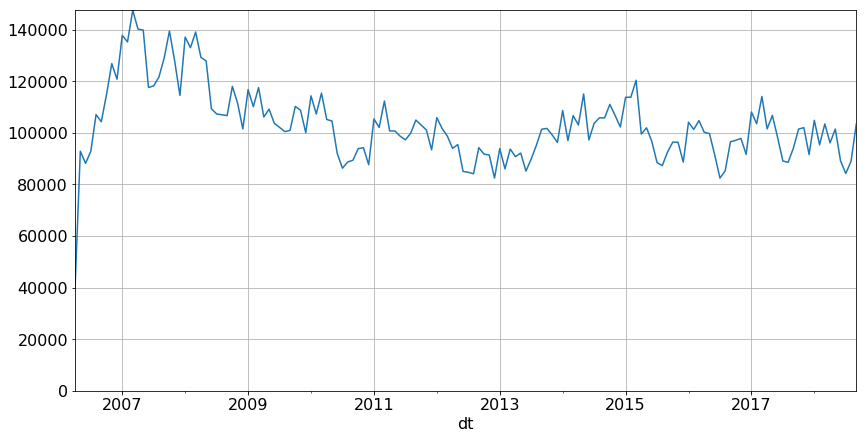

In [9]:
global_new_eds.plot(ylim=0);

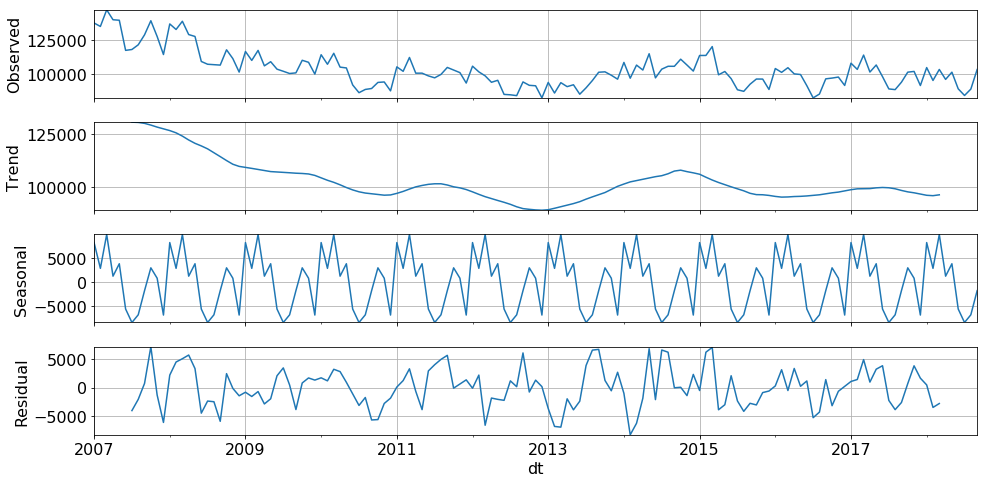

In [15]:
result = seasonal_decompose(global_new_eds["2007":], model='additive')
result.plot();

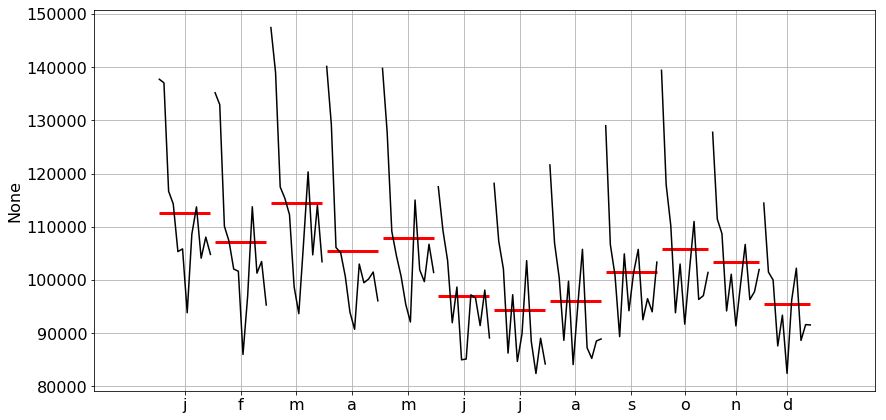

In [17]:
sm.graphics.tsa.month_plot(global_new_eds["2007":]);

# New *active* editors

In [ ]:
new_act = wmf.mariadb.run("""
    select 
    month,
    wiki,
    sum(extract(year_month from user_registration) = extract(year_month from month)) as new_actives
    from staging.editor_month
    where
    month >= "2013-01-01" and
    content_edits >= 5 and
    local_user_id != 0 and
    bot_flag = 0 and (
        convert(user_name using utf8) not regexp "bot\\\\b" or
        user_name in ("Paucabot", "Niabot", "Marbot")    
    )
    group by month, wiki
""")

new_act["month"] = new_act["month"].apply(pd.to_datetime)
new_act = new_act.set_index(["wiki", "month"])

new_act.head()

In [ ]:
# Fill in missing zero-value rows
wikis = new_act.index.unique(level="wiki")
mos = new_act.index.unique(level="month")

wiki_mo_idx = pd.MultiIndex.from_product([wikis, mos], names=['wiki', 'month'])
new_act = new_act.reindex(wiki_mo_idx, fill_value=0)

In [ ]:
new_act

# Global new and new active

In [ ]:
glob_new = wmf.hive.run("""
select
    date_format(event_user_creation_timestamp, "yyyy-MM-01") as mon,
    count(*) as new_editors,
    sum(cast(30_d_content_edits >= 5 as int)) as new_active_editors
from (
    select
        event_user_creation_timestamp,
        count(*) as 30_d_edits,
        sum(cast(page_namespace_is_content_historical as int)) as 30_d_content_edits
    from wmf.mediawiki_history
    where 
        snapshot = "2018-06" and
        event_entity = "revision" and
        event_type = "create" and
        not (event_user_is_bot_by_name or array_contains(event_user_groups, "bot")) and
        not event_user_is_anonymous and
        not event_user_is_created_by_system and
        event_timestamp <= date_add(event_user_creation_timestamp, 30)
    group by user_text, event_user_creation_timestamp
) day_30
group by date_format(event_user_creation_timestamp, "yyyy-MM-01")
""")

In [ ]:
glob_new.tail()

In [ ]:
ax = glob_new["new_editors"].plot(label="new editors", legend=True, ylim=0)
glob_new["new_active_editors"].plot(secondary_y=True, label="new active editors", legend=True)
ax.right_ax.set_ylim(0);

# Gainer and loser wikis

In [ ]:
cur_mo = new_act.index.unique(level="month").max().to_pydatetime()
cur_yr = pd.date_range(end=cur_mo, periods=12, freq="MS")
base_mo = cur_mo - relativedelta(years=3)
base_yr = pd.date_range(end=base_mo, periods=12, freq="MS")

print("Current year:", cur_yr[0], "–", cur_yr[-1])
print("Base year:", base_yr[0], "–", base_yr[-1])

In [ ]:
r_new_act = new_act.groupby(level="wiki").apply(lambda x: x.rolling(12).mean())

In [ ]:
def long_term_change(df):
    df = df.reset_index(level=0, drop=True)
    return df.loc[cur_mo] - df.loc[base_mo]

change = r_new_act.groupby(level="wiki").apply(long_term_change).sort_values(by="new_actives", ascending=False).dropna()

In [ ]:
display(change.head(10))
display(change.tail(10))

# Seasonal analysis

In [ ]:
monthly_new = wmf.mariadb.run("""
    select 
        month, 
        sum(extract(year_month from reg) = extract(year_month from month)) as new_active_editors
    from (
        select 
            month, user_name, sum(content_edits) as content_edits, 
            min(user_registration) as reg, max(bot_flag) as bot_flag
        from staging.editor_month
        where local_user_id != 0
        group by month, user_name
    ) global_edits
    where
        content_edits >= 5 and 
        bot_flag = 0 and
        convert(user_name using utf8) not regexp "bot\\b" and
        convert(user_name using utf8) not regexp "[ _]bot[ _]"
    group by month
""")

In [ ]:
monthly_new = monthly_new.set_index(pd.DatetimeIndex(monthly_new["month"])).drop("month", axis = 1)

In [ ]:
monthly_new.head()

In [ ]:
monthly_new.plot();

In [ ]:
monthly_new["2016-05-01":].plot()

In [ ]:
new_act_decomp = seasonal_decompose(monthly_new.loc["2008-01-01":], model='additive')
new_act_decomp.plot();

In [ ]:
new_act_decomp.seasonal.tail(12).plot()

# Wikipedia new editor retention

In [ ]:
proj_ret = wmf.hive.run(
    """
    select 
        wiki,
        cohort as reg_mo,
        count(*) as new_eds,
        (sum(if(2nd_month_edits >= 1, 1, 0)) / sum(if(1st_month_edits >= 1, 1, 0))) as ret
    from neilpquinn.new_editors
    group by wiki, cohort
    order by wiki, cohort asc
    limit 250000
    """
)

In [ ]:
wikipedias = wmf.utils.list_wikis(["wikipedia"])

def segment(w):
    if w == "enwiki":
        return "English Wikipedia"
    elif w in wikipedias:
        return "Other Wikipedias"
    else:
        return "Other projects"

proj_ret["group"] = proj_ret["wiki"].apply(segment)

In [ ]:
def avg_ret(df):
    return (df["new_eds"] * df["ret"]).sum() / df["new_eds"].sum()

wp_ret = proj_ret.query("group != 'Other projects'")
wp_ret = pd.DataFrame(wp_ret.groupby(["group", "reg_mo"]).apply(avg_ret)).reset_index().pivot("reg_mo", "group")
wp_ret.columns = wp_ret.columns.droplevel(0)
wp_ret.index = pd.to_datetime(wp_ret.index)

wp_ret.tail()

In [ ]:
wp_ret["2003":].plot(ylim=0, title="new Wikipedia editor retention")
plt.ylabel("retention rate")
plt.xlabel("")
ax = plt.gca()
ax.legend().set_title("")
ax.yaxis.set_major_formatter(pct_fmt)
plt.autoscale(enable=True, axis="x", tight=True);

In [ ]:
de_ret = proj_ret.query("wiki == 'dewiki'")
de_ret.set_index(pd.to_datetime(de_ret["reg_mo"]), drop=True)["ret"]["2014-05":].plot(ylim=0, title="German Wikipedia new editor retention")
plt.ylabel("retention rate")
plt.xlabel("")
ax = plt.gca()
ax.legend().set_title("")
ax.yaxis.set_major_formatter(pct_fmt)
plt.autoscale(enable=True, axis="x", tight=True)
plt.savefig("dewiki.png");

In [ ]:
de_ret.to_csv("dewiki_ret.tsv", sep="\t", index=False)

# New editor cohort size vs. retention

In [18]:
hive.run("""
describe
neilpquinn.new_editors
""")

,col_name,data_type,comment
0,user_name,string,
1,wiki,string,
2,user_id,bigint,
3,cohort,string,
4,1st_month_edits,bigint,
5,2nd_month_edits,bigint,


In [20]:
cohort_size_retention_r = hive.run("""
select
    wiki,
    count(*) as new_eds,
    sum(cast(2nd_month_edits >= 1 as int)) / count(*) as new_ed_retention_rate
from neilpquinn.new_editors
where
    cohort between "2017-11" and "2018-11"
group by wiki
""")

In [27]:
cohort_size_retention = cohort_size_retention_r.copy()
cohort_size_retention = cohort_size_retention.query("new_eds >= 100")

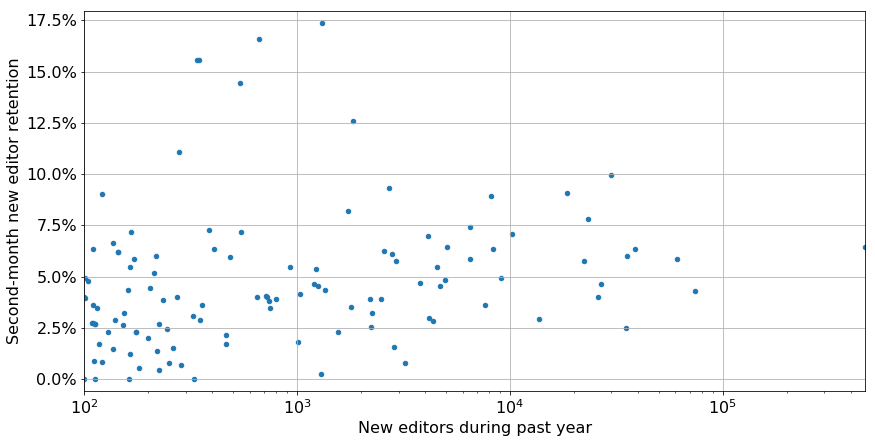

In [31]:
ax = cohort_size_retention.plot.scatter(x="new_eds", y="new_ed_retention_rate")
ax.set_xscale("log")
ax.set_ylabel("Second-month new editor retention")
ax.set_xlabel("New editors during past year")
ax.yaxis.set_major_formatter(pct_fmt);

In [37]:
cohort_size_retention.query("new_eds >= 1000").sort_values("new_ed_retention_rate", ascending=False).head(20)

,wiki,new_eds,new_ed_retention_rate
465,hywiki,1317,0.173880
50,etwiki,1840,0.126087
284,jawiki,30005,0.099317
157,srwiki,2720,0.093382
202,zhwiki,18574,0.090718
67,hewiki,8193,0.089100
392,azwiki,1742,0.082090
281,itwiki,23334,0.078212
367,ukwiki,6488,0.074291
134,plwiki,10202,0.070770


In [40]:
cohort_size_retention.query("new_eds >= 1000").sort_values("new_ed_retention_rate").head(20)

,wiki,new_eds,new_ed_retention_rate
240,enwikinews,1295,0.002317
499,mediawikiwiki,3202,0.007808
108,metawiki,2852,0.015778
241,enwikiquote,1008,0.017857
430,enwikivoyage,1552,0.023196
226,commonswiki,35330,0.025134
347,simplewiki,2226,0.025157
267,hiwiki,4378,0.028095
74,idwiki,13710,0.029540
322,nowiki,4178,0.029679


In [29]:
cohort_size_retention.query("new_ed_retention_rate >= 0.1")

,wiki,new_eds,new_ed_retention_rate
45,enwikiversity,540,0.144444
50,etwiki,1840,0.126087
62,glwiki,280,0.110714
233,dewikiversity,341,0.155425
247,euwiki,664,0.165663
465,hywiki,1317,0.173880
469,incubatorwiki,347,0.155620


# Registrations vs. new editors

In [49]:
registrations = hive.run("""
select
    wiki,
    count(*) as registrations
from event.serverSideAccountCreation
where
    event.isSelfMade = 1 and
    ((year = 2017 and month >= 11) or (year=2018 and month < 11))
group by wiki
""")

In [72]:
registrations_new_eds = (
    registrations
    .set_index("wiki")
    .join(cohort_size_retention_r.set_index("wiki"))
    .assign(
        activation=lambda df: df["new_eds"] / df["registrations"],
        long_term_activation=lambda df: (df["new_eds"] * df["new_ed_retention_rate"]) / df["registrations"])
    .query("new_eds >= 100")
)

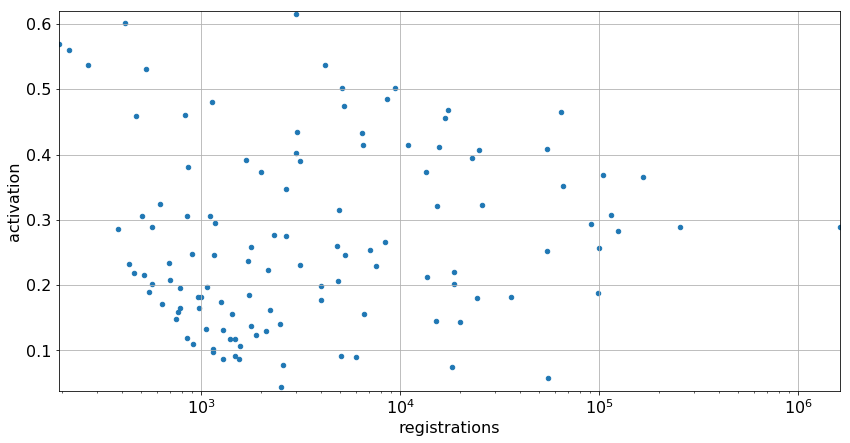

In [61]:
ax = registrations_new_eds.plot.scatter(x="registrations", y="activation")
ax.set_xscale("log")

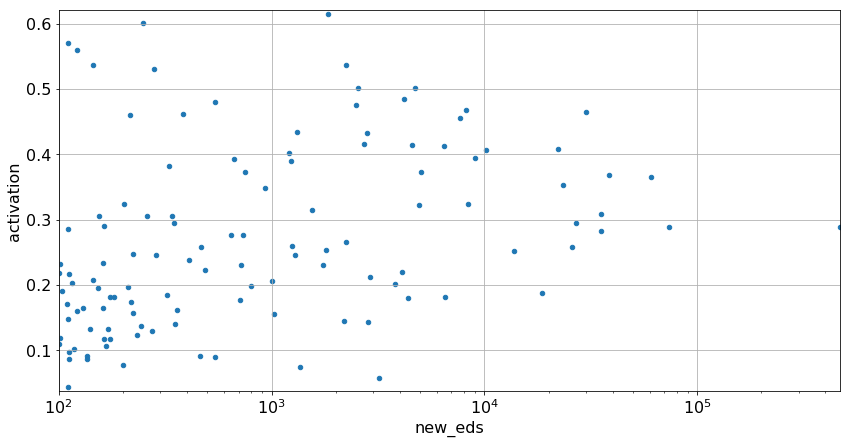

In [64]:
ax = registrations_new_eds.plot.scatter(y="activation", x="new_eds")
ax.set_xscale("log")

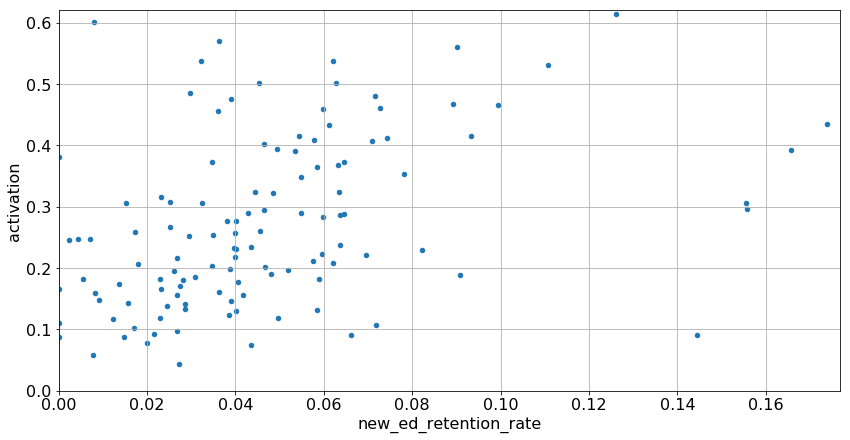

In [71]:
ax = registrations_new_eds.plot.scatter(y="activation", x="new_ed_retention_rate", ylim=0, xlim=0)

In [67]:
registrations_new_eds.query("new_eds >= 1000").sort_values("activation", ascending=False).head(10)

,registrations,new_eds,new_ed_retention_rate,activation
wiki,,,,
etwiki,2994,1840.0,0.126087,0.614562
bgwiki,4175,2244.0,0.032086,0.537485
cawiki,5089,2553.0,0.062671,0.501670
fiwiki,9398,4711.0,0.045213,0.501277
nowiki,8609,4178.0,0.029679,0.485306
dawiki,5231,2485.0,0.039034,0.475053
hewiki,17515,8193.0,0.089100,0.467770
jawiki,64492,30005.0,0.099317,0.465252
svwiki,16828,7673.0,0.036101,0.455966


In [75]:
registrations_new_eds.sort_values("long_term_activation", ascending=False).head(20)

,registrations,new_eds,new_ed_retention_rate,activation,long_term_activation
wiki,,,,,
etwiki,2994,1840.0,0.126087,0.614562,0.077488
hywiki,3030,1317.0,0.173880,0.434653,0.075578
euwiki,1693,664.0,0.165663,0.392203,0.064973
glwiki,528,280.0,0.110714,0.530303,0.058712
cywiki,218,122.0,0.090164,0.559633,0.050459
dewikiversity,1116,341.0,0.155425,0.305556,0.047491
jawiki,64492,30005.0,0.099317,0.465252,0.046207
incubatorwiki,1174,347.0,0.155620,0.295571,0.045997
hewiki,17515,8193.0,0.089100,0.467770,0.041679


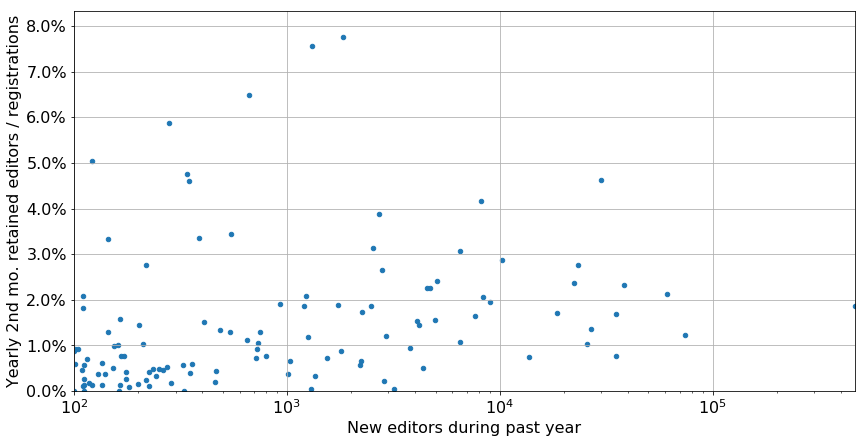

In [81]:
ax = registrations_new_eds.plot.scatter(y="long_term_activation", x="new_eds", ylim=0)
ax.set_xscale("log")
ax.set_ylabel("Yearly 2nd mo. retained editors / registrations")
ax.set_xlabel("New editors during past year")
ax.yaxis.set_major_formatter(charting.pct_fmt);

In [83]:
(
    registrations_new_eds
    .query("new_eds >= 10000")
    .sort_values("long_term_activation", ascending=False).head(20)
)

,registrations,new_eds,new_ed_retention_rate,activation,long_term_activation
wiki,,,,,
jawiki,64492,30005.0,0.099317,0.465252,0.046207
plwiki,25044,10202.0,0.070770,0.407363,0.028829
itwiki,66217,23334.0,0.078212,0.352387,0.027561
fawiki,54501,22257.0,0.057825,0.408378,0.023614
dewiki,104826,38575.0,0.063227,0.367991,0.023267
frwiki,166688,60834.0,0.058454,0.364957,0.021333
enwiki,1619430,467600.0,0.064568,0.288744,0.018644
zhwiki,98706,18574.0,0.090718,0.188175,0.017071
ruwiki,124853,35371.0,0.059851,0.283301,0.016956


# Additional things to investigate:
* Long-term vs short-term retention